Download the dataset

In [1]:
!pip install -U --no-cache-dir gdown --pre 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown 1m9kUcxRvDSPmJ8AJ-OzB_UJq0GdsW4lO

Downloading...
From: https://drive.google.com/uc?id=1m9kUcxRvDSPmJ8AJ-OzB_UJq0GdsW4lO
To: /content/Stone_Dataset.zip
100% 1.28G/1.28G [00:09<00:00, 129MB/s] 


In [3]:
!unzip /content/Stone_Dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: Normal/1.3.46.670589.33.1.63736883278072760700001.4865153372974908858.png  
 extracting: Normal/1.3.46.670589.33.1.63736883278102762400001.4890800610987426837.png  
  inflating: Normal/1.3.46.670589.33.1.63736980428746417400001.5369893332672664726.png  
  inflating: Normal/1.3.46.670589.33.1.63736980428785419600001.5389164795912807806.png  
  inflating: Normal/1.3.46.670589.33.1.63736980428822421700001.5309248432970235768.png  
  inflating: Normal/1.3.46.670589.33.1.63736980428861424000001.5716838844742545197.png  
  inflating: Normal/1.3.46.670589.33.1.63736980428902426300001.5705929841034914536.png  
  inflating: Normal/1.3.46.670589.33.1.63736982522587178200001.4881981787674798765.png  
  inflating: Normal/1.3.46.670589.33.1.63736982522623180300001.5601499372740300159.png  
  inflating: Normal/1.3.46.670589.33.1.63736982522657182200001.5366479165204974149.png  
  inflating: Normal/1.3.46.670589.33.1.63736982522690184100

Import necessary libraries

In [4]:
import os
import pandas as pd
import numpy as np
import shutil, math, cv2, json, random
from tqdm import tqdm
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Downsample to reduce bias

In [5]:
source_1 = "/content/Dataset/Normal"
source_2 = "/content/Dataset/Stone"

files_1 = os.listdir(source_1)
files_2 = os.listdir(source_2)

for i, j in enumerate(files_1):
    if i >= len(files_2):
        os.remove(os.path.join(source_1, j))

In [6]:
sdir = '/content/Dataset'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

Stone                  : 100%|██████████████████████████████████████████| 1310/1310 [00:18<00:00, 72.56file/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1048   the minimum files in any class in train_df is  1048
train_df length:  2096   test_df length:  262   valid_df length:  262
average image height=  829   average image width=  820  aspect ratio h/w=  1.0109756097560976


In [7]:
def normalized_data(img):
    img = img / 255.0
    img -= np.mean(img, axis=(0,1))
    img /= (np.std(img, axis=(0,1)) + 1e-7)
    return img 

In [8]:
batch_size = 8
img_size = (224, 224)
input_shape = (224, 224, 3)

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(
        horizontal_flip=True, 
        rotation_range=90,
        preprocessing_function=lambda img: normalized_data(img))
    t_and_v_gen = ImageDataGenerator(
        horizontal_flip=True, 
        rotation_range=90,
        preprocessing_function=lambda img: normalized_data(img)
    )
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=False)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 2096 validated image filenames belonging to 2 classes.
Found 262 validated image filenames belonging to 2 classes.
Found 262 validated image filenames belonging to 2 classes.
test batch size:  1 test steps:  262 number of classes :  2


### **Construct the neural network**

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

# Create a ResNet50 model
resnet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet50_output = resnet50_base.output

# Create a VGG16 model
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg16_output = vgg16_base.output

# Combine the outputs of the ResNet50 and VGG16 models
combined_output = Flatten()(resnet50_output)

# Define custom layers
x = Reshape((7, 7, 2048))(combined_output)
x = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(x)
x = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

combined_output = Flatten()(x)
combined_output = Dense(units=256, activation='relu')(combined_output)
combined_output = Dropout(0.5)(combined_output)
combined_output = Dense(units=2, activation='softmax')(combined_output)

# Create a new model that combines the ResNet50 and VGG16 models
model = Model(inputs=[resnet50_base.input], outputs=combined_output, 
              name="CNNV2")

# Compile model
model.compile(optimizer='SGD', loss='categorical_crossentropy', 
              metrics=['accuracy','AUC'])

model.summary()

Model: "CNNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
history = model.fit(train_ds, epochs=8, batch_size=batch_size, 
                    validation_data=valid_ds)

Epoch 1/8
262/262 [==============================] - 80s 256ms/step - loss: 0.7476 - accuracy: 0.7042 - auc: 0.7623 - val_loss: 0.7614 - val_accuracy: 0.5000 - val_auc: 0.5252
Epoch 2/8
262/262 [==============================] - 66s 250ms/step - loss: 0.3054 - accuracy: 0.8569 - auc: 0.9420 - val_loss: 0.3714 - val_accuracy: 0.7824 - val_auc: 0.9114
Epoch 3/8
262/262 [==============================] - 67s 255ms/step - loss: 0.1757 - accuracy: 0.9184 - auc: 0.9807 - val_loss: 0.2298 - val_accuracy: 0.9084 - val_auc: 0.9697
Epoch 4/8
262/262 [==============================] - 65s 249ms/step - loss: 0.1709 - accuracy: 0.9289 - auc: 0.9820 - val_loss: 0.1717 - val_accuracy: 0.9275 - val_auc: 0.9844
Epoch 5/8
262/262 [==============================] - 66s 251ms/step - loss: 0.1379 - accuracy: 0.9490 - auc: 0.9880 - val_loss: 0.1403 - val_accuracy: 0.9351 - val_auc: 0.9874
Epoch 6/8
262/262 [==============================] - 66s 252ms/step - loss: 0.1262 - accuracy: 0.9509 - auc: 0.9896 - va

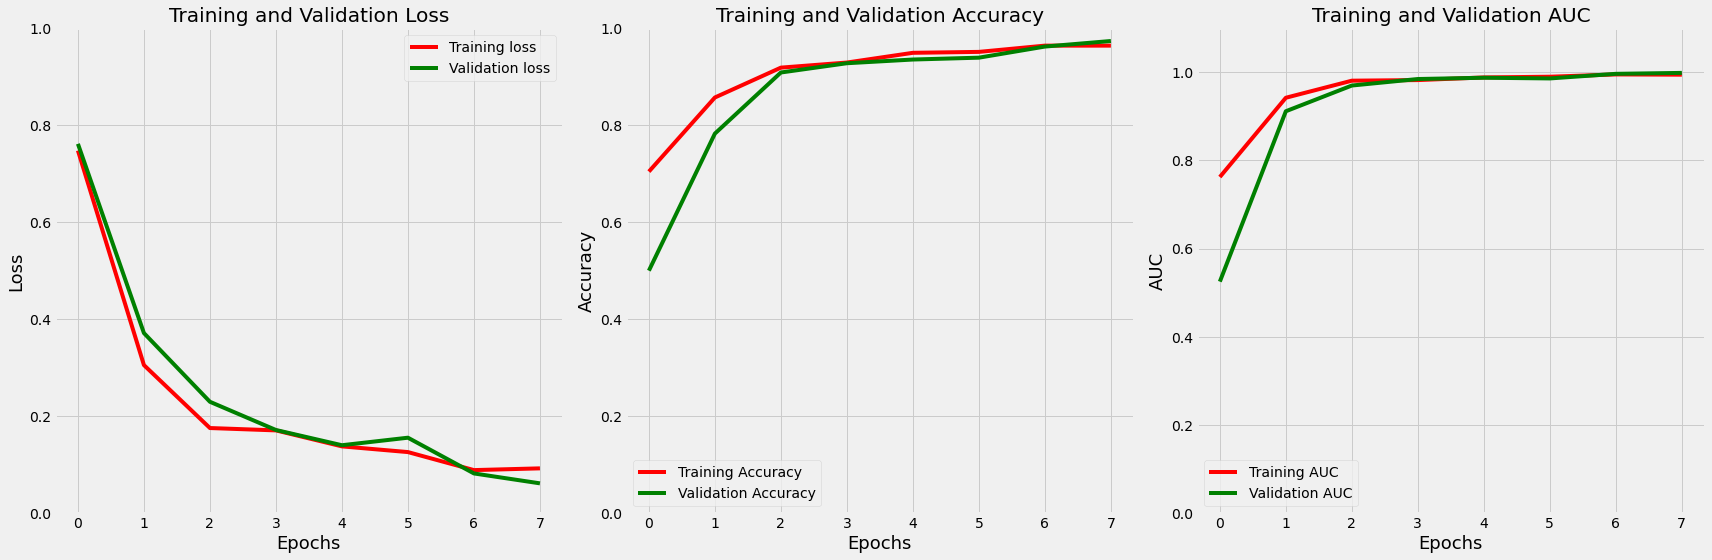

In [14]:
def plot_auc_acc_loss(epochs):
    tacc = history.history['accuracy']
    tloss = history.history['loss']
    tauc = history.history['auc']

    vacc = history.history['val_accuracy']
    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    axes[0].plot(tloss, 'r', label='Training loss')
    axes[0].plot(vloss, 'g', label='Validation loss')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(tacc, 'r', label='Training Accuracy')
    axes[1].plot(vacc, 'g', label='Validation Accuracy')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    axes[2].plot(tauc, 'r', label='Training AUC')
    axes[2].plot(vauc, 'g', label='Validation AUC')
    axes[2].set_ylim(0, 1.1)
    axes[2].set_title('Training and Validation AUC')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('AUC', fontsize=18)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return Epochs


Epochs = plot_auc_acc_loss(epochs=5)

33/33 [==============================] - 7s 181ms/step
there were 8 errors in 262 tests for an accuracy of  96.95%


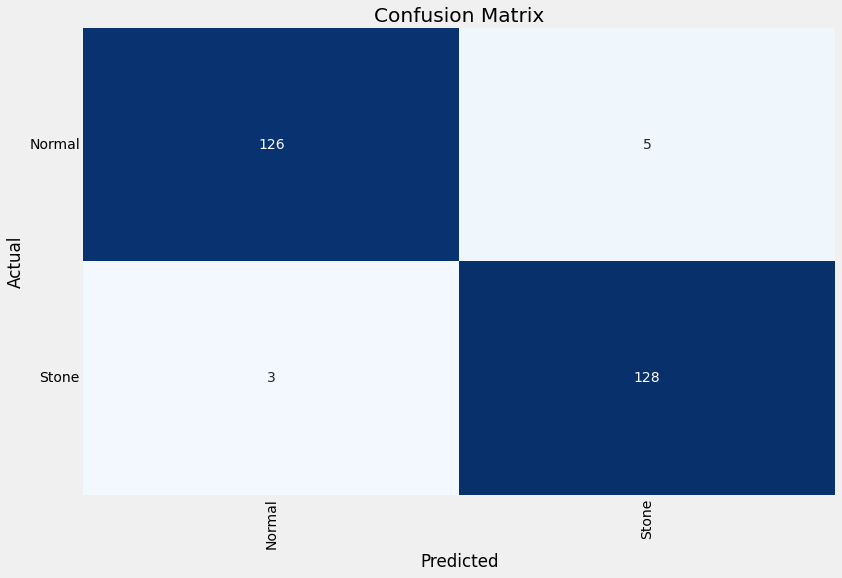



Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal     0.9767    0.9618    0.9692       131
       Stone     0.9624    0.9771    0.9697       131

    accuracy                         0.9695       262
   macro avg     0.9696    0.9695    0.9695       262
weighted avg     0.9696    0.9695    0.9695       262



In [15]:
def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(model.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("\n\nClassification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)